# DP

In [ ]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(100, 10)
    
    def forward(self, x):
        return self.fc1(x)

net = Model().cuda()
net = nn.DataParallel(module=net, device_ids=[0, 1], output_device=0)

toy_x = torch.randn(1000, 100).cuda()
toy_y = torch.randn(1000, 10).cuda()
criterion = nn.MSELoss()

output = net(toy_x)
print(output.shape)
print(output.device)

# DDP

In [ ]:
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim

from torch.nn.parallel import DistributedDataParallel as DDP

class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = nn.Linear(10, 10)
        self.relu = nn.ReLU()
        self.net2 = nn.Linear(10, 5)

    def forward(self, x):
        return self.net2(self.relu(self.net1(x)))


def demo_basic():
    dist.init_process_group("nccl")
    rank = dist.get_rank()
    print(f"Start running basic DDP example on rank {rank}.")

    # create model and move it to GPU with id rank
    device_id = rank % torch.cuda.device_count()
    model = ToyModel().to(device_id)
    ddp_model = DDP(model, device_ids=[device_id])

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

    optimizer.zero_grad()
    outputs = ddp_model(torch.randn(20, 10))
    labels = torch.randn(20, 5).to(device_id)
    loss_fn(outputs, labels).backward()
    optimizer.step()
    dist.destroy_process_group()

if __name__ == "__main__":
    demo_basic()
    
# export MASTER_ADDR=$(scontrol show hostname ${SLURM_NODELIST} | head -n 1)
# torchrun --nnodes=2 --nproc_per_node=8 --rdzv_id=100 --rdzv_backend=c10d --rdzv_endpoint=$MASTER_ADDR:29400 elastic_ddp.py

# Pytorch Lightning DDP

In [ ]:
# https://lightning.ai/docs/pytorch/stable/accelerators/gpu_intermediate.html#distributed-training-strategies
import torch
import torch.nn as nn
import lightning as pl
import os
from lightning.pytorch import LightningModule


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(100, 10)
    
    def forward(self, x):
        return self.fc1(x)
    
    
class Module(LightningModule):
    def __init__(self):
        super(Module, self).__init__()
        self.model = Model()
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    
class ToyDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

    def train_dataloader(self):
        toy_x = torch.randn(1000, 100)
        toy_y = torch.randn(1000, 10)
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(toy_x, toy_y), batch_size=32)
    
    def val_dataloader(self):
        toy_x = torch.randn(1000, 100)
        toy_y = torch.randn(1000, 10)
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(toy_x, toy_y), batch_size=32)
    
    def test_dataloader(self):
        toy_x = torch.randn(1000, 100)
        toy_y = torch.randn(1000, 10)
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(toy_x, toy_y), batch_size=32)
    
    
def main(): 
    # MASTER_ADDR
    os.environ["MASTER_ADDR"] = "localhost"
    datamodule = ToyDataModule()
    module = Module()
    trainer = pl.Trainer(accelerator="auto", 
                         max_epochs=1,
                         strategy="ddp"
                         )
    trainer.fit(module, datamodule=datamodule)
    
if __name__ == "__main__":
    main()
        

# Model Parallelism

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10, 10).to('cuda:0')
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10, 5).to('cuda:1')

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))
        return self.net2(x.to('cuda:1'))

# Tensor Parallelism

In [ ]:
class linear_identity_allreduce(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight):
	# simple forward
        ctx.save_for_backward(input, weight)
        output = torch.matmul(input, weight.t())
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
	# allreduce in backward
        input, weight = ctx.saved_tensors
        tp_group = get_tensor_parallel_group()
        grad_input = torch.matmul(grad_output, weight)
        torch.distributed.all_reduce(grad_input, group=tp_group, async_op=True)
        
        grad_output = grad_output.contiguous()
        grad_output = grad_output.view(grad_output.shape[0] * grad_output.shape[1],
                                       grad_output.shape[2])
        input = input.view(input.shape[0] * input.shape[1], input.shape[2])
        grad_weight = torch.matmul(grad_output.t(), input)
        return grad_input, grad_weight


class ColumnParallelLinear(nn.Module):
    """linear layer with column parallelism
    
    The linear layer is defined as Y = XA + b. A is parallelized along
    its second dimension as A = [A_1, ..., A_p].
    """
    
    def __init__(
        self, 
        input_size: int, 
        output_size: int,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        tp_group = get_tensor_parallel_group()
        tp_size = tp_group.size()

        assert output_size % tp_size == 0, \\
            "output_size must be divisible by tensor parallel size"
        self.output_size_partition = output_size // tp_size
        
        self.weights = torch.nn.Parameter(torch.empty(
            self.output_size_partition, self.input_size))
        nn.init.xavier_uniform_(self.weights)
        
    def forward(self, input_: torch.Tensor):
        args = [input_, self.weights]
        out = linear_identity_allreduce.apply(*args)
        return out

# Frameworks

In [ ]:
from lightning.pytorch import Trainer

model = MyModel()
trainer = Trainer(accelerator="gpu", devices=4, strategy="deepspeed_stage_3", precision=16)
trainer.fit(model)

<!-- set white background for matplotlib -->


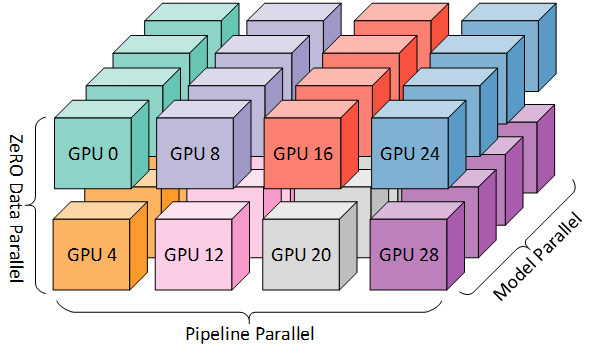
